<div dir="rtl" align="center">
<font face="XB Zar" size=5>
    <font face="IranNastaliq" size=5>
      به نام خدا
    </font>
    <br>
    <font size=3>
      دانشگاه صنعتی شریف - دانشکده مهندسی کامپیوتر
    </font>
    <br>
    <font color=blue size=5>
      مقدمه‌ای بر یادگیری ماشین
    </font>
    <br>
    <hr/>
    <font color=red size=6>
      فصل هفتم: GRU, LSTM
    </font>
    <br>
      نویسندگان:‌ علیرضا دهقانپور فراشاه
    <hr>
<br>
  <div align="right">
  <font color="red" size=5>فهرست مطالب</font>
	<ul>
    <li>
        <a href='#intro'>
        مقدمه
        <ul>
          <li>
            <a href="#dataset">
              آشنایی با دیتاست
            </a>
          </li>
          <li>
            <a href="#preprocessing">
              آماده سازی دیتاست
            </a>
          </li>
        </ul>
    </a>
		</li>
		<li>
      <a href="#architecture">
       تعریف معماری مدل
      </a>
    </li>
    <li>
      <a href="#training">
       آموزش مدل
      </a>
    </li>
    <li>
      <a href="#test">
       تست مدل
      </a>
    </li>
    <li>
      <a href="#gru">
       مدل GRU      </a>
    </li>
    <li>
      <a href="#bdlstm">
       Bidirectional LSTM      </a>
    </li>
    <li>
      <a href="#cleantext">
       تمیز کردن متون      </a>
    </li>
    <li>
      <a href="#nextwordtest">
     تست مدل next word prediction     </a>
    </li>
    </li>
    </div>
</font>
</div>


  <div dir=rtl id="intro">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
        مقدمه
      </font>
      <hr />
      شبکه های عصبی بازگشتی که در بخش قبل دیدیم با مشکل vanishing gradient همراه بودند. برای رفع این مشکل سراغ LSTM رفتیم که همانطور که در اسلایدها مشاهده کردید تا حدی این ایراد را برطرف میکند و میتواند توالی بزرگتری از داده را به خاطر بسپرد.  
      </br>
      در این بخش میخواهیم با استفاده از LSTM قیمت سهام IBM را پیش بینی کنیم.

</font>
</div>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout, GRU
import math
from sklearn.metrics import mean_squared_error


  <div dir=rtl id="dataset">
  <font face="XB Zar" size=4>
      <font color="red" size=5>
        آشنایی با دیتاست
      </font>
      <hr />
        در این بخش میخواهیم ستون 
        <font face="Roboto">high</font>
        را با استفاده از مدل های بازگشتی با
        <font face="Roboto">LSTM</font>
        و 
        <font face="Roboto">GRU</font>
        پیش بینی کنیم.
  </font>
  </div>

In [ ]:
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

In [ ]:
dataset.describe()

In [ ]:
dataset.info()


  <div dir=rtl id="preprocessing">
    <font face="XB Zar" size=4>
      <font color="red" size=5>آماده سازی دیتاست</font>
      <hr />
      در این بخش داده را به دو بخش
      <font face="Roboto">Train</font>
      و
      <font face="Roboto">Test</font>
      تقسیم میکنیم.
       بخش 
      <font face="Roboto">Test</font>
      در واقع بخشی است که با مدل قیمت سهام را پیش بینی میکنیم و با مقدار واقعی آن مقایسه میکنیم.
      سال ۲۰۱۷ را برای پیش بینی به عنوان تست در نظر میگیریم.    ‍
  </div>

In [ ]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

In [ ]:
dataset["High"][:'2016'].plot(figsize=(12,4),legend=True)
dataset["High"]['2017':].plot(figsize=(12,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

<div dir=rtl>
<font face="XB Zar" size=4>
<hr/>
      از 
      <font face="Roboto">MinMaxScaler</font>  
        برای نرمال کردن داده ها استفاده میکنیم تا اعداد بین ۰ و ۱ قرار بگیر‍ن‍د‍ و همچنین از هر ۶۰ 
         ‍‍‍‍<font face="Roboto">timestep</font>
         برای پیش بینی بعدی استفاده میکنیم. 
         بنابراین داده را به این صورت میسازیم که هر ۶۰
         <font face="Roboto">timestep</font>
         یک بردار نامپای خواهد شد که به ازای آن یک خروجی
<font face="Roboto">$y^{<t>}$</font>
         خواهیم داشت که مقدار پیش بینی شده است.

</div>


In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape


<div dir="rtl" id="architecture">
    <font face="XB Zar" size=4>
      <font color="red" size=5>
        تعریف معماری مدل
      </font>
      <hr />
در این مدل از چند لایه 
<font face="Roboto">LSTM</font>
استفاده میکنیم.
</br>
در هر لایه پارامتر
<font face="Roboto">unit</font>
بُعد خروجی را مشخص میکند.
یعنی انتظار داریم بردارهای 
<font face="Roboto">$a^{<t>}$</font>
و
<font face="Roboto">$c^{<t>}$</font>
هر کدام یک بردار
<font dir="ltr" face="Roboto">$(50, 1)$</font>
باشند.
    </div>

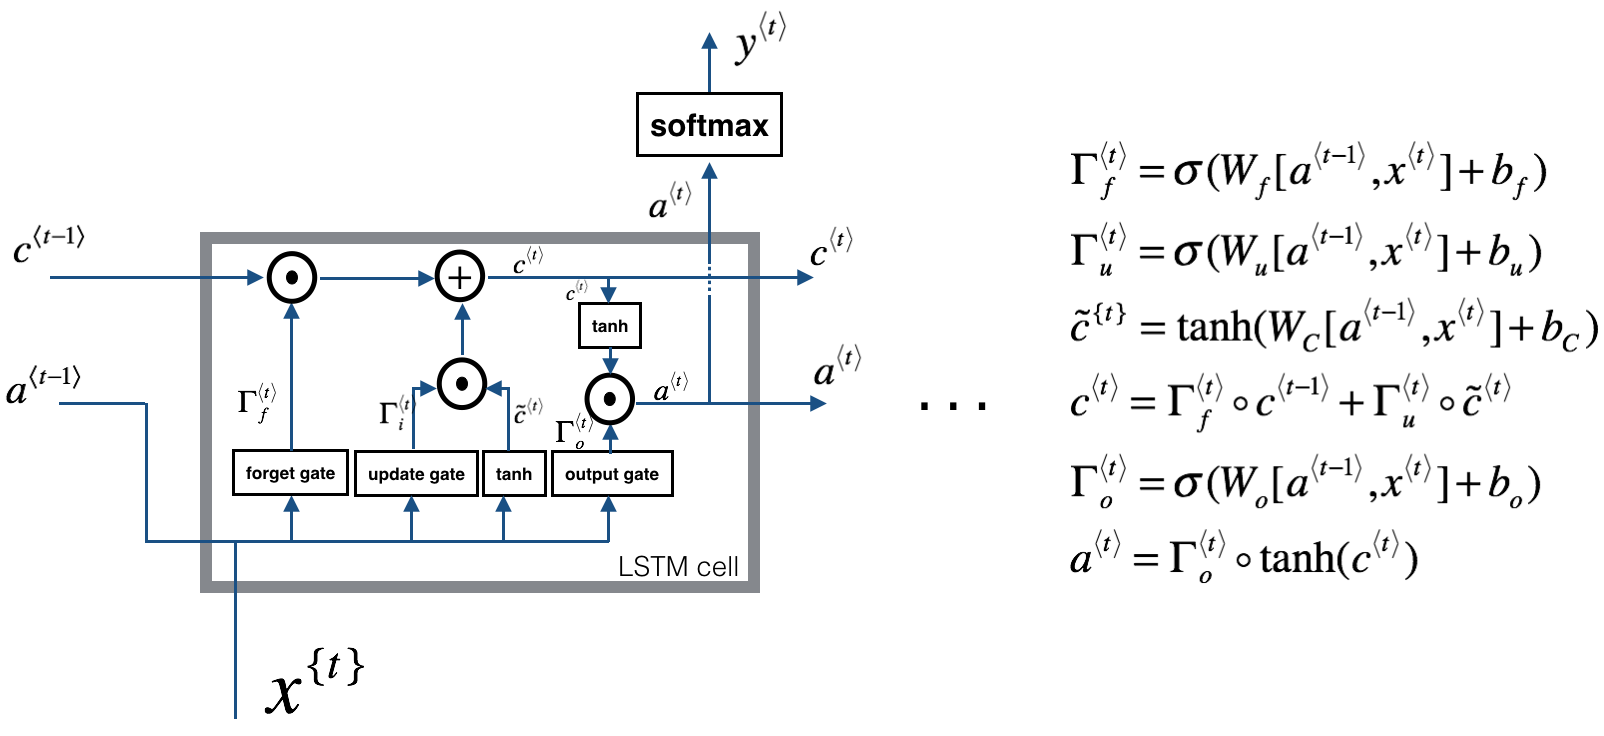

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.summary()


  <div dir="rtl" id="architecture">
    <font face="XB Zar" size=4>
      <hr />
تعداد پارامترها به این صورت است که داده ورودی ما یک بردار
<font dir="ltr" face="Roboto">$(60, 1)$</font>
است که یعنی تعداد 
<font  face="Roboto">feature</font>
برابر ۱ است. یعنی 
<font dir="ltr" face="Roboto">$x^{<t>}$</font>
یک عدد است.
</br>
 بنابراین ماتریس های 
<font face="Roboto">$W_f, W_u, W_c, W_o$</font>
همگی ماتریس هایی
<font face="Roboto">$(50, 51)$</font>
همچنین بردارهای بایاس 
<font face="Roboto">$b_f, b_u, b_c, b_o$</font>
همگی
<font face="Roboto">$(50, 1)$</font>
هستند. بنابراین کل پارامترهای لایه اول میشود:
    <center>
    <font face="Roboto">$4\times(50\times 51 + 50) = 10400$</font>
    </center>
</br>
برای لایه های بعدی تعداد 
<font face="Roboto">feature</font>
به جای یک عدد ۵۰ بعدی است بنابراین ماتریس ها میشوند
<font face="Roboto">$(50, 100)$</font>  
 و تعداد کل پارامترها میشود:
 </br>
 </br>
  <center>
   <font face="Roboto">$4\times(50\times 100 + 50) = 20200$</font>
    </center>
</div>

    

<div dir="rtl" id="training">
    <font face="XB Zar" size=4>
      <font color="red" size=5>
        آموزش مدل      </font>
      <hr />
در ادامه مدل را ترین می کنیم.
    </div>

In [ ]:
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor.fit(X_train,y_train,epochs=50,batch_size=32)

In [ ]:
regressor.save("lstm_ibmstock.h5")

<div dir="rtl" id="test">
    <font face="XB Zar" size=4>
      <font color="red" size=5>
       تست مدل
             </font>
      <hr />
در ابتدا نموداری را که میخواهیم مدل پیش بینی کند را رسم کرده و سپس 
<font face="Roboto">X_test</font>
را میسازیم و به مدل ورودی میدهیم و خروجی آن را در کنار مقدار واقعی رسم میکنیم.
    </div>

In [ ]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
dataset_total[len(dataset_total)-len(test_set) - 60:].plot(figsize=(8,6),c='orange')
plt.title('Test Part')
plt.show()

In [ ]:
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
len(inputs)

In [ ]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
plot_predictions(test_set,predicted_stock_price)

<div dir="rtl" id="gru">
    <font face="XB Zar" size=4>
      <font color="red" size=5>
       مدل GRU
             </font>
      <hr />
مدلی با معماری مدل قبل فقط با این تفاوت که به جای بلاک های 
<font face="Roboto">LSTM</font>
از
<font face="Roboto">GRU</font>
استفاده میکنیم. توجه کنید که در 
<font face="Roboto">GRU</font>
 </br>
 برای تعداد پارامتر به جای ۴ ماتریس وزن و بایاس ۳ ماتریس وزن و بایاس داریم زیرا یک گیت کمتر داریم. بنابراین تعداد پارامترهای لایه اول نسبت به قبل میشود:
    <center>
  <font face="Roboto">$3\times(50\times 51 + 50) = 7800$</font> 
     </center>
    </br>
    </br>
   و برای لایه های میانی میشود:
   </br>
   <center>
   <font face="Roboto">$3\times(50\times 100 + 50) = 15150$</font>
    </center>
  </div>

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*LNZTwVNuRQYZmUrtWDntGQ.png)

<a href="https://towardsdatascience.com/grus-and-lstm-s-741709a9b9b1">pic source</a>

In [ ]:
regressorGRU = Sequential()

regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, return_sequences=True,  activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(Dense(units=1))

regressorGRU.summary()

In [ ]:
regressorGRU.compile(optimizer='rmsprop', loss='mean_squared_error')


regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)


In [ ]:
regressorGRU.save("gru_ibmstock.h5")

In [ ]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
plot_predictions(test_set,GRU_predicted_stock_price)

<div dir="rtl" id=bdlstm>
    <font face="XB Zar" size=4>
      <font color="red" size=5>
       Bidirectional LSTM
             </font>
      <hr />
در این بخش سعی داریم با استفاده از
<font face="Roboto">Bidirectional LSTMs</font>
یک مدل برای تسک
<font face="Roboto">next word prediction</font>
آموزش دهیم. برای این کار از یک دیتاست که شامل عنوان های سایت 
<a href"medium.com">
<font face="Roboto">medium</font>
</a>
است استفاده میکنیم.
    </div>

In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
medium_data = pd.read_csv("medium_data.csv")
medium_data['title']

<div dir="rtl" id="cleantext">
    <font face="XB Zar" size=4>
      <font color="red" size=5>
       تمیز کردن متون
             </font>
      <hr />
این عناوین شامل کاراکترهایی است که باید حذف شوند.
سپس با استفاده از 
<font face="Roboto">tokenizer</font>
تمامی لغات این عناوین را
<font face="Roboto">index</font>
می کنیم.
همچنین این توالی ها را به اندازه بزرگترین توالی با عملیات 
<font face="Roboto">padding</font>
یک اندازه میکنیم.
    </div>

In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)

In [ ]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
print(input_sequences)
print("Total input sequences: ", len(input_sequences))

In [ ]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
max_sequence_len

<div dir="rtl" id="bdarchitecture">
    <font face="XB Zar" size=4>
      <font color="red" size=5>
       معماری مدل دو طرفه             </font>
      <hr />
هر داده آموزش ما شامل یک توالی از کلمات بدون کلمه آخر است که کلمه آخر درواقع برچسب آن داده است.
توجه کنید که لایه 
<font face="Roboto">Embedding</font>
نمایشی برای کلمات یاد خواهد گرفت که هر کلمه با یک بردار به طول ۱۰۰ قابل نمایش باشد پ چون ۸۲۳۸ کلمه داشتیم تعداد پارامترهایی قابل یادگیری آن ۸۲۳۸۰۰ است.
</br>
خروجی این لایه یک ماتریس به ابعاد
<font face="Roboto">$(39, 100)$</font>
است که ورودی به
<font face="Roboto">Bidirectonal LSTM</font>
داده میشود.
خروجی این لایه یک بردار به طول ۳۰۰ است که از اتصال دو بردار ۱۵۰تایی خروجی لایه رفت و برگشت تشکیل شده است.
    </div>

In [ ]:
x_train, labels = input_sequences[:,:-1],input_sequences[:,-1]
y_train = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.summary()


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50, verbose=1)

<div dir="rtl" id="nextwordtest">
    <font face="XB Zar" size=4>
      <font color="red" size=5>
        تست مدل next word prediction            </font>
      <hr />
در این قسمت با دادن کلمات ابتدایی و مشخص کردن تعداد کلمات بعدی با ورودی دادن توالی ابتدایی به مدل برداری از احتمال هر یک از کلمات بدست میاوریم و کلمه با بیشترین احتمال را انتخاب میکنیم و به توالی قبلی اضافه میکنیم و دوباره توالی جدید را به مدل ورودی میدهیم.
نمونه خروجی آن را مشاهده میکنید.
    </div>

In [ ]:
seed_text = "bidirectional recurrent"
next_words = 4
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index ==np.argmax(predicted, axis=1):
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)